# Bringing tomography and pulses together

In [1]:
from qiskit import IBMQ
import qiskit.tools.jupyter
%qiskit_job_watcher

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit.providers.ibmq import least_busy
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits > 1 
                                       and not x.configuration().simulator))

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [2]:
backend

<IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
def to_ptm2(op):
    pauli_list = [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]
    pauli2_list = []
    for pi in pauli_list:
        for pj in pauli_list:
            pauli2_list.append(qt.tensor(pi, pj))
    ptm = np.zeros((16, 16), dtype=complex)
    for idx_i, pi in enumerate(pauli2_list):
        for idx_j, pj in enumerate(pauli2_list):
            ptm[idx_i, idx_j] = (pi * op * pj * op.dag()).tr()/4
    return qt.Qobj(ptm)

def rotation(theta, phi, lam):
    U = [[np.cos(theta/2), -np.exp(1j*lam) * np.sin(theta/2)], 
         [np.exp(1j*phi) * np.sin(theta/2), np.exp(1j*lam+1j*phi) * np.cos(theta/2)]]
    return qt.Qobj(U)

def objective2(angles, *args):
    theta1, phi1, lam1, theta2, phi2, lam2 = angles
    U1 = to_ptm2(qt.tensor(qt.qeye(2), rotation(theta1, phi1, lam1)))
    U2 = to_ptm2(qt.tensor(rotation(theta2, phi2, lam2), qt.qeye(2)))
    U = U1 * U2
    G, G_ideal = args
    norm = np.linalg.norm((G_ideal - U * G)) ** 2
    return norm

## Process tomography for the CNOT gate

In [5]:
from qiskit.circuit import QuantumRegister, QuantumCircuit
from qiskit.ignis.verification.tomography import process_tomography_circuits
from qiskit.execute import execute

register = QuantumRegister(2)
circuit = QuantumCircuit(register)
circuit.cx(0, 1)

experiments = process_tomography_circuits(circuit, [register[0], register[1]])
result = []

for n in range(len(experiments)//75 + 1): 
    job = execute(experiments[n*75: (n+1)*75], backend, optimization_level=0, shots=5000)
    result.append(job.result())
    print(job.job_id())

5e585f5780d4ed0018a8cb21
5e586183e9ff470019b091d3


CP? True. TP? False.
Norm(ideal, real): 0.33227950584272253.


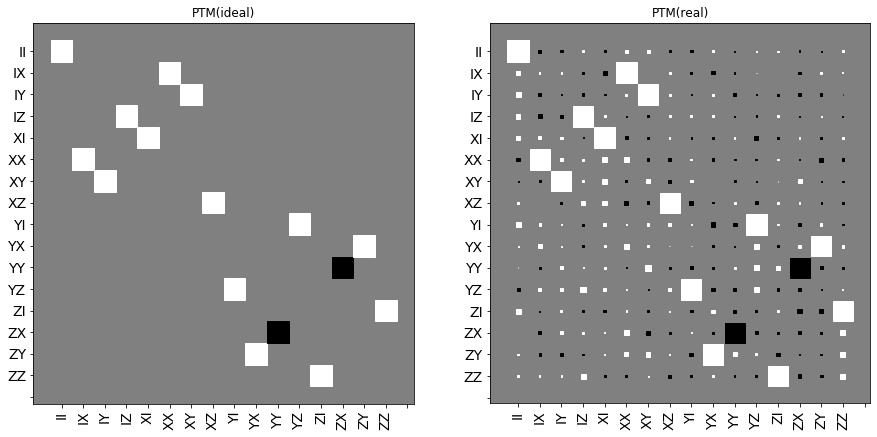

In [6]:
from qiskit.ignis.verification.tomography import ProcessTomographyFitter
from qiskit.quantum_info import PTM
from qiskit.visualization import plot_state_hinton

tomography = []
tomography = ProcessTomographyFitter(result[0], experiments[:75])
for n in range(1, len(experiments)//75 + 1):
    tomography.add_data(result[n], experiments[n*75 : (n+1)*75])
choi = tomography.fit()
ptm = qt.Qobj(PTM(choi).data)

ptm_ideal = to_ptm2(qt.cnot(2, 1, 0))
ptm_norm_before =  np.linalg.norm((ptm - ptm_ideal).full()) ** 2

pauli_list = ['I', 'X', 'Y', 'Z']
pauli_labels = []
for pi in pauli_list:
    for pj in pauli_list:
        pauli_labels.append(pi+pj)

fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
plot_state_hinton(ptm_ideal.dag(), ax_real=axs[0])
plot_state_hinton(ptm.dag(), ax_real=axs[1])
title_list = ['PTM(ideal)', 'PTM(real)']
for idx, ax in enumerate(axs):
    ax.set_title(title_list[idx]);
    ax.set_xticklabels(pauli_labels)
    ax.set_yticklabels(pauli_labels)

print('CP? '+str(choi.is_cp())+'.', 'TP? '+str(choi.is_tp())+'.')
print('Norm(ideal, real): '+str(ptm_norm_before)+'.')

## Calculating the gate corrections

[-0.00463268 -0.61982287  0.62238    -0.00366151 -0.01534204  0.00470707]
Norm(ideal, ideal corrected): 0.32164240456635734.


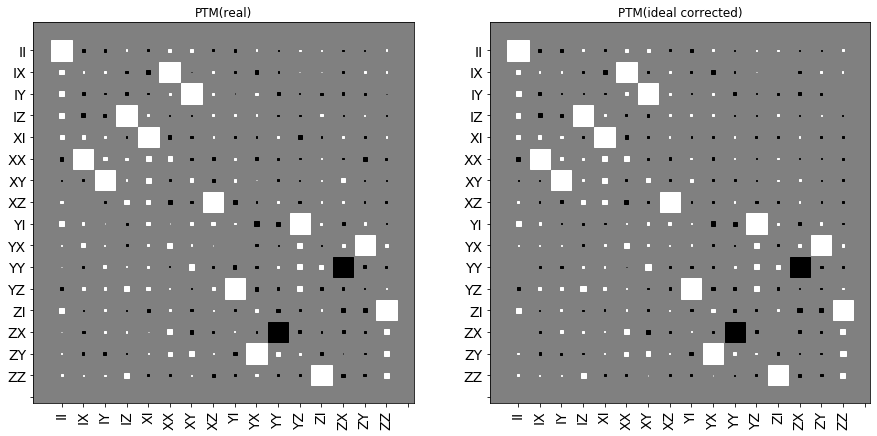

In [12]:
from scipy.optimize import minimize
guess = .5 * np.random.randn(6, 1) 
#bounds = ((np.pi/2, np.pi/2), (np.pi/2, np.pi/2), (np.pi/2, np.pi/2))
solution = minimize(objective2, guess, args=(ptm, ptm_ideal), tol=1e-12)
angles = solution.x

theta1, phi1, lam1, theta2, phi2, lam2 = angles
U1 = to_ptm2(qt.tensor(qt.qeye(2), rotation(theta1, phi1, lam1)))
U2 = to_ptm2(qt.tensor(rotation(theta2, phi2, lam2), qt.qeye(2)))
U = U1 * U2

ptm_th = U * ptm
ptm_norm_th =  np.linalg.norm((ptm_th - ptm_ideal).full()) **2

pauli_list = ['I', 'X', 'Y', 'Z']
pauli_labels = []
for pi in pauli_list:
    for pj in pauli_list:
        pauli_labels.append(pi+pj)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
plot_state_hinton(ptm.dag(), ax_real=axs[0])
plot_state_hinton(ptm_th.dag(), ax_real=axs[1])
title_list = ['PTM(real)', 'PTM(ideal corrected)']
for idx, ax in enumerate(axs):
    ax.set_title(title_list[idx])
    ax.set_xticklabels(pauli_labels)
    ax.set_yticklabels(pauli_labels)

print(angles/np.pi)
print('Norm(ideal, ideal corrected): '+str(ptm_norm_th)+'.')

## Process tomography for the "corrected" CNOT gate

In [8]:
import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

register = QuantumRegister(2)
circuit_corr = QuantumCircuit(register)
circuit_corr.u3(theta1, phi1, lam1, 0)
circuit_corr.u3(theta2, phi2, lam2, 1)
circuit_corr.cx(0, 1)
circuit_corr.u3(-theta2, -lam2, -phi2, 1)
circuit_corr.u3(-theta1, -lam1, -phi1, 0)

experiments_corr = process_tomography_circuits(circuit_corr, [register[0], register[1]])
result_corr = []

for n in range(len(experiments_corr)//75 + 1): 
    job_corr = execute(experiments_corr[n*75: (n+1)*75], backend, optimization_level=0, shots=5000)
    result_corr.append(job_corr.result())
    print(job_corr.job_id())

5e58640e55eb6e001878958a
5e5865c5116fb100188a6a05


CP? True. TP? False.
Norm(real corrected, ideal): 0.4549323462404047.
Norm(real corrected, ideal corrected): 0.11415447947857658.


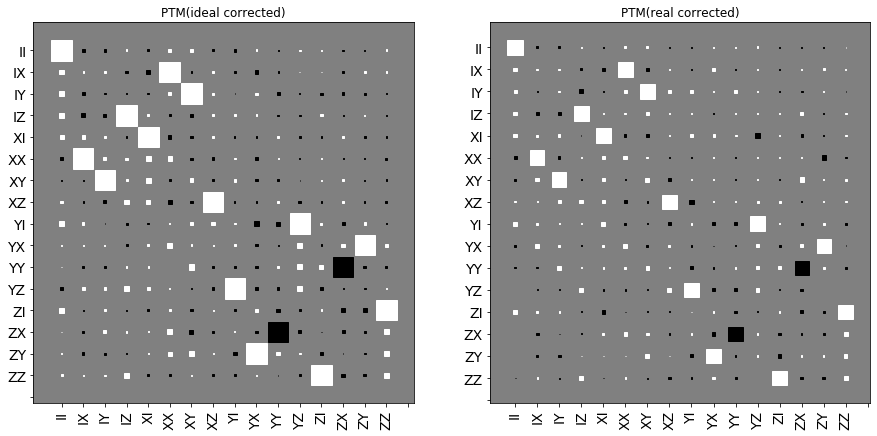

In [11]:
tomography_corr = []
tomography_corr = ProcessTomographyFitter(result_corr[0], experiments_corr[:75])
for n in range(1, len(experiments_corr)//75 + 1):
    tomography_corr.add_data(result_corr[n], experiments_corr[n*75 : (n+1)*75])
choi_corr = tomography_corr.fit()
ptm_corr = qt.Qobj(PTM(choi_corr).data)

ptm_norm_after =  np.linalg.norm((ptm_corr - ptm_ideal).full()) ** 2
ptm_norm_miss =  np.linalg.norm((ptm_corr - ptm_th).full()) ** 2

pauli_list = ['I', 'X', 'Y', 'Z']
pauli_labels = []
for pi in pauli_list:
    for pj in pauli_list:
        pauli_labels.append(pi+pj)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
plot_state_hinton(ptm_th.dag(), ax_real=axs[0])
plot_state_hinton(ptm_corr.dag(), ax_real=axs[1])
title_list = ['PTM(ideal corrected)', 'PTM(real corrected)']
for idx, ax in enumerate(axs):
    ax.set_title(title_list[idx])
    ax.set_xticklabels(pauli_labels)
    ax.set_yticklabels(pauli_labels)

print('CP? '+str(choi_corr.is_cp())+'.', 'TP? '+str(choi_corr.is_tp())+'.')
print('Norm(real corrected, ideal): '+str(ptm_norm_after)+'.')
print('Norm(real corrected, ideal corrected): '+str(ptm_norm_miss)+'.')